# Liesel-GAM Demo Notebook

## Setup and Imports

In [1]:
import jax.numpy as jnp
import liesel.goose as gs
import liesel.model as lsl
import numpy as np
import pandas as pd
import plotnine as p9
import tensorflow_probability.substrates.jax.distributions as tfd

import liesel_gam as gam

In [2]:
from ryp import r, to_py

In [3]:
r("library(mgcv)")
r("data(columb)")
r("data(columb.polys)")

Loading required package: nlme
This is mgcv 1.9-3. For overview type 'help("mgcv-package")'.


In [4]:
columb = to_py("columb", format="pandas").reset_index()
polys = to_py("columb.polys", format="numpy")

In [5]:
def polys_to_df(polys):
    poly_labels = list(polys)
    poly_coords = list(polys.values())
    poly_coord_dim = np.shape(poly_coords[0])[-1]
    poly_df = pd.concat(
        [
            pd.DataFrame(
                poly_coords[i], columns=[f"V{i}" for i in range(poly_coord_dim)]
            ).assign(vertex=lambda df: df.index + 1, id=i, label=poly_labels[i])
            for i in range(len(polys))
        ],
        ignore_index=True,
    )
    return poly_df

In [6]:
poly_df = polys_to_df(polys)

In [7]:
columb["label"] = columb["district"]
poly_df = columb.merge(poly_df, on="label")

In [8]:
def plot_polys(df, color, polys, label):
    poly_df = polys_to_df(polys)
    df["label"] = df[label]
    plot_df = df.merge(poly_df, on="label")
    p = (
        p9.ggplot(plot_df)
        + p9.aes("V0", "V1", group="label", fill=color)
        + p9.geom_polygon()
    )
    return p

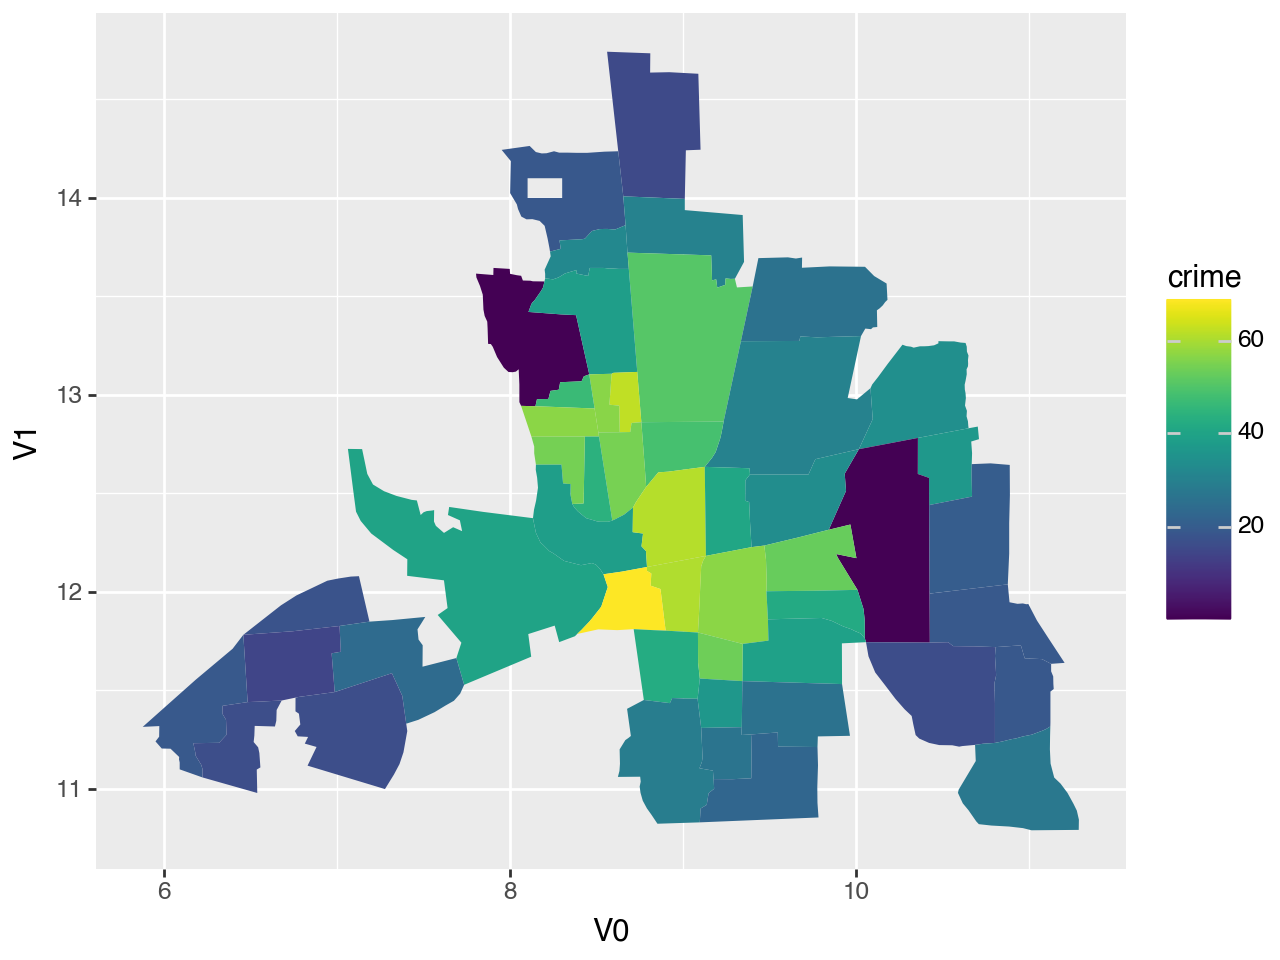

In [9]:
plot_polys(columb, "crime", polys, "district")

## Model Definition

### Setup response model

In [10]:
df = columb

loc = gam.AdditivePredictor("$\\mu$")
scale = gam.AdditivePredictor("$\\sigma$", inv_link=jnp.exp)


y = lsl.Var.new_obs(
    value=df.crime.to_numpy(),
    distribution=lsl.Dist(tfd.Normal, loc=loc, scale=scale),
    name="y",
)

In [11]:
tb = gam.TermBuilder.from_df(df)

In [12]:
df.columns

Index(['index', 'area', 'home.value', 'income', 'crime', 'open.space',
       'district', 'x', 'y', 'label'],
      dtype='object')

In [13]:
df.head()

,index,area,home.value,income,crime,open.space,district,x,y,label
0,0,0.309441,80.467003,19.531,15.725980,2.850747,0,8.827218,14.369076,0
1,1,0.259329,44.567001,21.232,18.801754,5.296720,1,8.332658,14.031624,1
2,2,0.192468,26.350000,15.956,30.626781,4.534649,2,9.012265,13.819719,2
3,3,0.083841,33.200001,4.477,32.387760,0.394427,3,8.460801,13.716962,3
4,4,0.488888,23.225000,11.252,50.731510,0.405664,4,9.007982,13.296366,4


In [14]:
smooth = tb.ps("area")
loc += smooth, tb.rs(x=smooth, cluster="district"), tb.ri("district", noncentered=True)

### Build and plot model

liesel.model.model - INFO - Converted dtype of Value(name="y_value").value


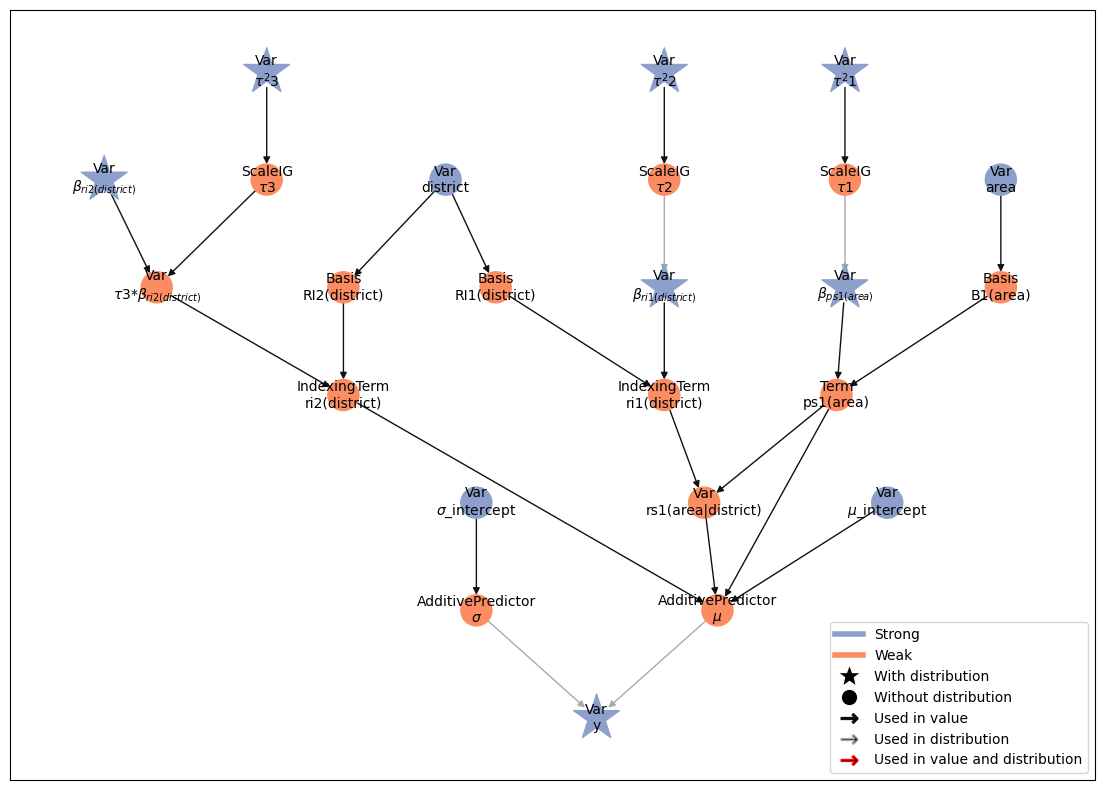

In [15]:
model = lsl.Model([y])
model.plot_vars()

## Run MCMC

Since we used the `inference` arguments to specify MCMC kernels for all parameters above,
we can quickly set up the MCMC engine with `gs.LieselMCMC` (new in v0.4.0).

In [16]:
eb = gs.LieselMCMC(model).get_engine_builder(
    seed=1, num_chains=4
)  # New in liesel v0.4.0

eb.set_epochs(
    gs.stan_epochs(
        warmup_duration=1000,
        posterior_duration=10000,
        init_duration=400,
        term_duration=400,
        thinning_posterior=10,
    )
)
engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys '$\\sigma$_intercept', '$\\mu$_intercept', '$\\beta_{ri2(district)}$', '$\\tau^2$3', '$\\beta_{ri1(district)}$', '$\\tau^2$2', '$\\beta_{ps1(area)}$', '$\\tau^2$1'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 400 transitions, 25 jitted together
100%|████████████████████████████████████████| 16/16 [00:05<00:00,  2.76chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|█████████████████████████████████████████| 1/1 [00:00<00:00, 304.42chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 50 transitions, 25 jitted together
100%|█████████████████████████████████████████| 2/2 [00:00<00:00, 425.80ch

### MCMC summary

In [17]:
summary = gs.Summary(results)
summary

Parameter summary:

                              kernel       mean         sd     q_0.05  \
parameter           index                                               
$\beta_{ps1(area)}$ (0,)   kernel_06  -0.000254   0.477287  -0.737185   
                    (1,)   kernel_06  -0.009588   0.466934  -0.770108   
                    (2,)   kernel_06  -0.016041   0.471573  -0.760221   
                    (3,)   kernel_06   0.013570   0.469234  -0.692128   
                    (4,)   kernel_06  -0.004001   0.481078  -0.734348   
...                              ...        ...        ...        ...   
$\mu$_intercept     ()     kernel_01  35.045731   2.076592  31.584722   
$\sigma$_intercept  ()     kernel_00   2.626161   0.118954   2.439085   
$\tau^2$1           ()     kernel_07   0.226492   0.392980   0.005114   
$\tau^2$2           ()     kernel_05   0.031466   0.096978   0.001651   
$\tau^2$3           ()     kernel_03   2.181163  14.262347   0.001133   

                               q_0.5     q_0.95  sample_size     ess_bulk  \
parameter           index                                                   
$\beta_{ps1(area)}$ (0,)   -0.000476   0.732682         4000  2958.544615   
                    (1,)   -0.005997   0.713946         4000  3590.399183   
                    (2,)   -0.006876   0.715969         4000  3359.293677   
                    (3,)    0.003775   0.758056         4000  3470.357379   
                    (4,)   -0.004122   0.739392         4000  3373.493394   
...                              ...        ...          ...          ...   
$\mu$_intercept     ()     35.065111  38.420711         4000  3640.261304   
$\sigma$_intercept  ()      2.624405   2.824024         4000  1209.793626   
$\tau^2$1           ()      0.120395   0.778318         4000   216.799642   
$\tau^2$2           ()      0.007192   0.130620         4000    97.432490   
$\tau^2$3           ()      0.017541   6.116681         4000   436.874838   

                              ess_tail      rhat  
parameter           index                         
$\beta_{ps1(area)}$ (0,)   2474.349287  1.012442  
                    (1,)   2509.580443  1.005069  
                    (2,)   2583.615274  1.009770  
                    (3,)   2572.767348  1.006335  
                    (4,)   2215.875495  1.010115  
...                                ...       ...  
$\mu$_intercept     ()     3487.096694  1.000179  
$\sigma$_intercept  ()     2191.747004  1.003225  
$\tau^2$1           ()      362.346144  1.021547  
$\tau^2$2           ()       80.126125  1.025745  
$\tau^2$3           ()      502.658221  1.009390  

[122 rows x 10 columns]

## Plots

In [18]:
samples = results.get_posterior_samples()

In [19]:
from liesel_gam.plots import plot_1d_smooth_clustered, plot_1d_smooth

In [20]:
list(model.vars)

['y',
 '$\\sigma$',
 '$\\sigma$_intercept',
 '$\\mu$',
 '$\\mu$_intercept',
 'ri2(district)',
 '$\\tau$3*$\\beta_{ri2(district)}$',
 '$\\beta_{ri2(district)}$',
 '$\\tau$3',
 '$\\tau^2$3',
 'RI2(district)',
 'district',
 'rs1(area|district)',
 'ri1(district)',
 '$\\beta_{ri1(district)}$',
 '$\\tau$2',
 '$\\tau^2$2',
 'RI1(district)',
 'ps1(area)',
 '$\\beta_{ps1(area)}$',
 '$\\tau$1',
 '$\\tau^2$1',
 'B1(area)',
 'area']

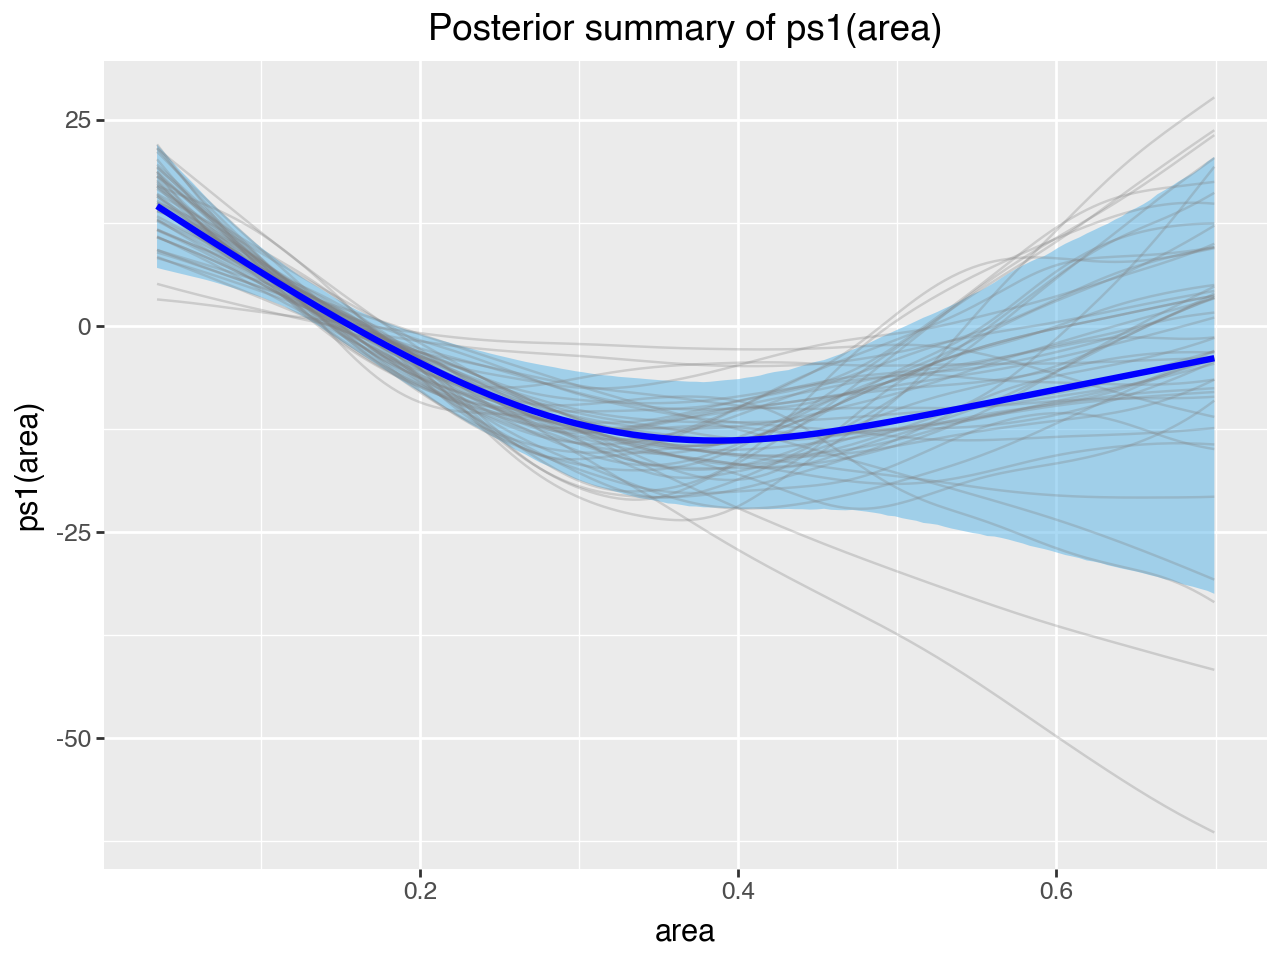

In [21]:
plot_1d_smooth(model.vars[smooth.name], samples)

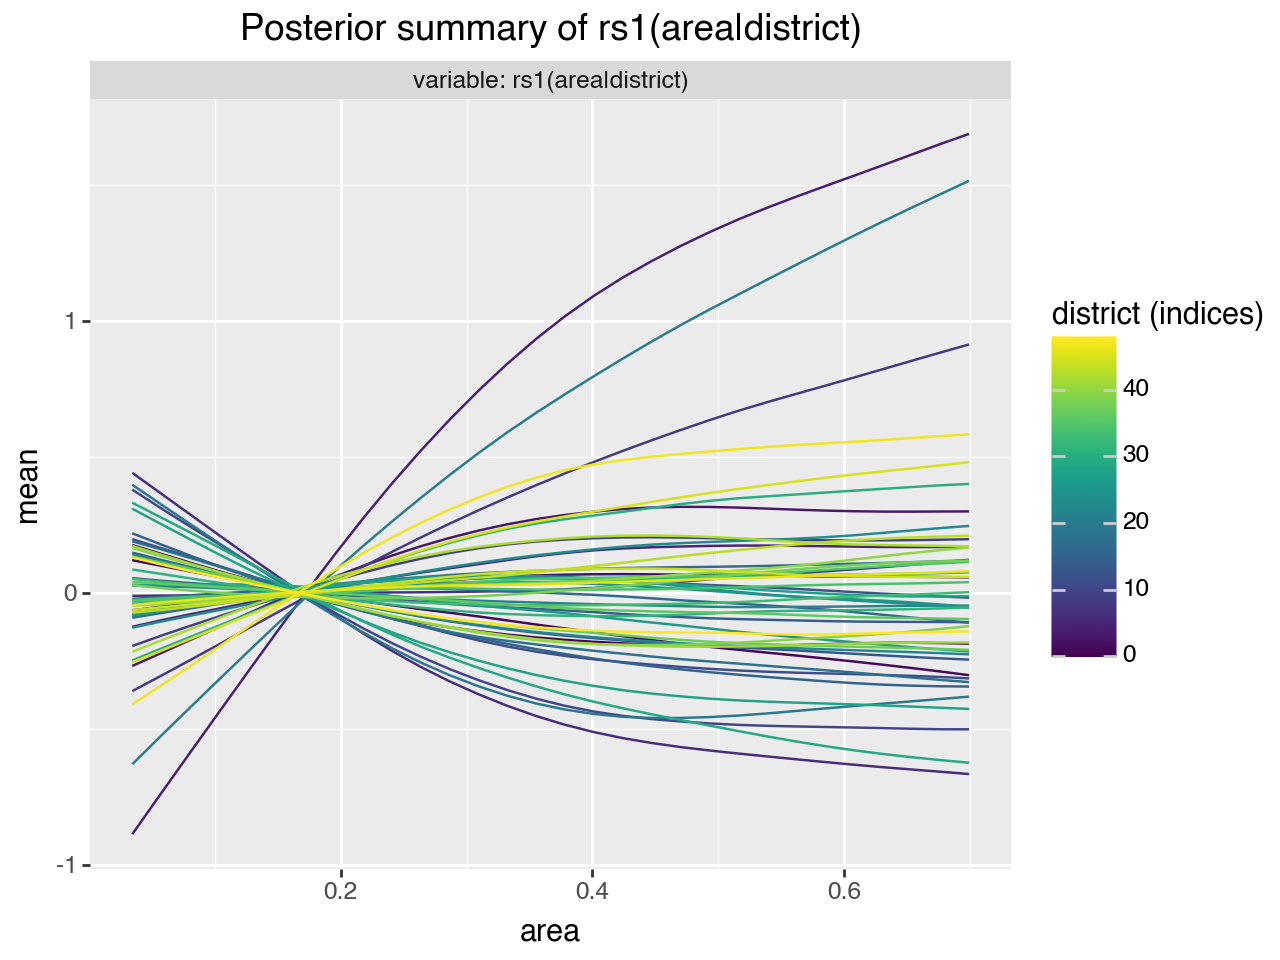

In [22]:
plot_1d_smooth_clustered(
    term=model.vars["rs1(area|district)"],
    x=model.vars["area"],
    cluster=model.vars["district"],
    samples=samples,
    ngrid=30,
)

In [23]:
from liesel_gam.plots import plot_regions

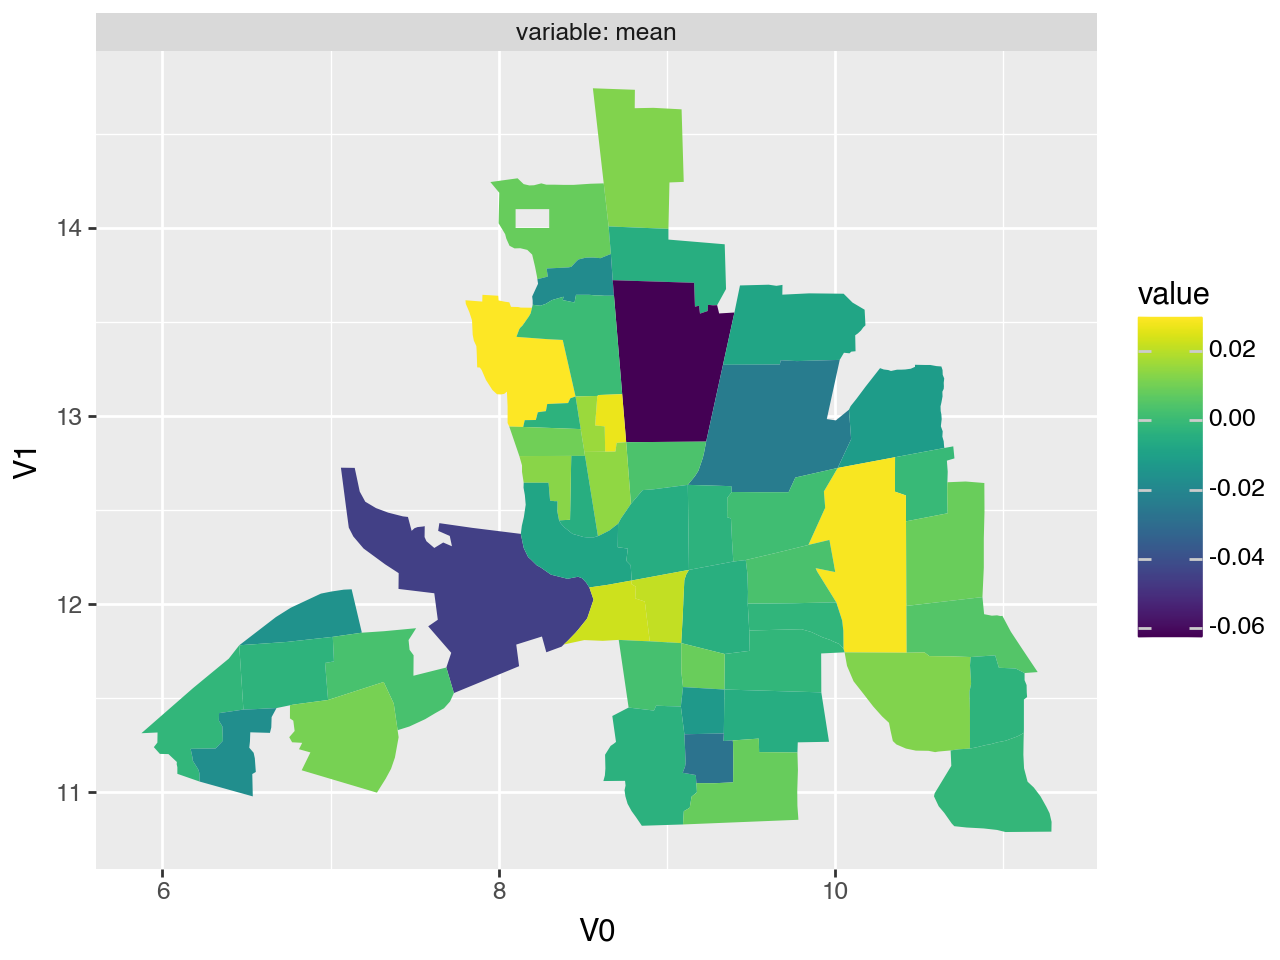

In [24]:
plot_regions(model.vars["ri1(district)"], samples, polys=polys)

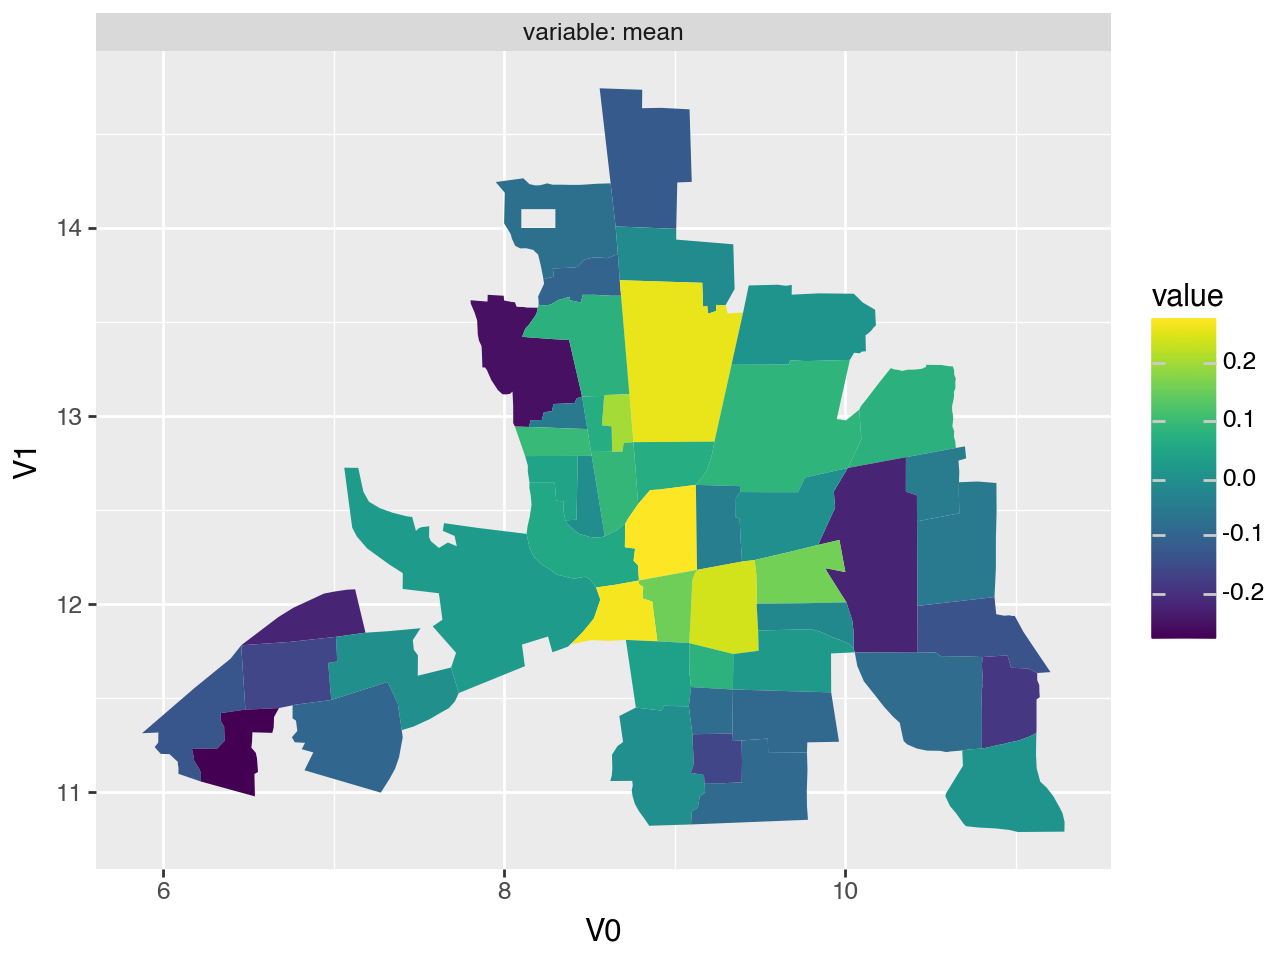

In [25]:
plot_regions(model.vars["ri2(district)"], samples, polys=polys)